# Experiment Template

**Team Member:** Liliane Umwanankabandi

**Model:**  Logistic Regression

**Embedding:** TF-IDF, Word2Vec Skip-gram, and Word2Vec CBOW


---

## 1. Setup & Imports

In [ ]:
!pip install gensim

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set plot style
sns.set(style="whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Load Data

In [ ]:
DATA_PATH = '/content/drive/MyDrive/data/IMDB Dataset.csv'
if not os.path.exists(DATA_PATH):
    print(f"Warning: {DATA_PATH} not found. Please ensure the dataset is in the data folder.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully: {df.shape}")
    display(df.head())

Dataset loaded successfully: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Exploratory Data Analysis (EDA)
Understanding the dataset characteristics.

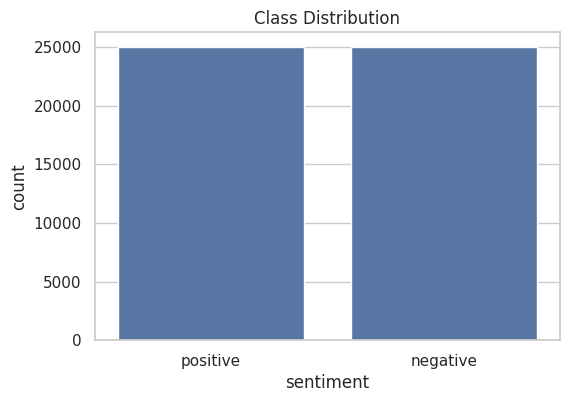

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
if 'sentiment' in df.columns:
    # Class Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df)
    plt.title('Class Distribution')
    plt.show()
    print(df['sentiment'].value_counts())

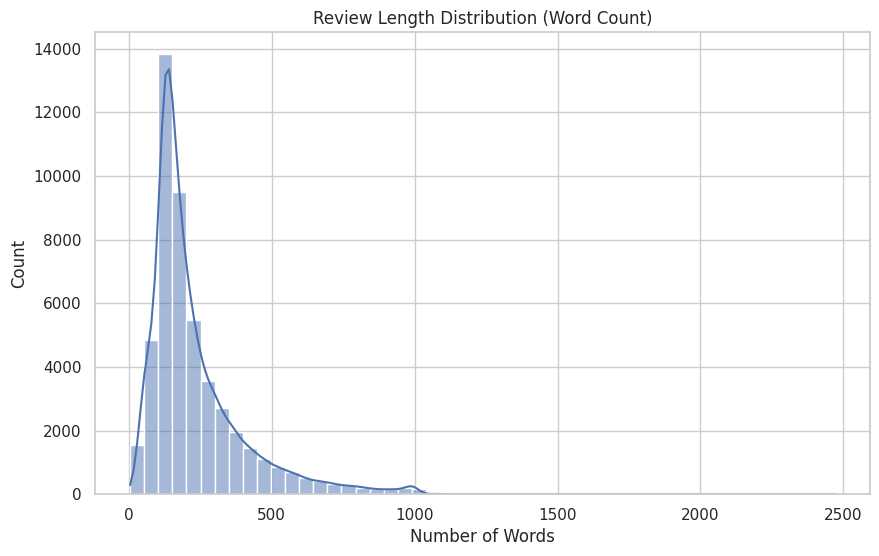

Average word count: 231.16


In [ ]:
# Review Length Analysis
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Review Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.show()

print(f"Average word count: {df['word_count'].mean():.2f}")

## 4. Preprocessing
Applying shared preprocessing strategy:
1. Lowercase
2. Remove HTML tags
3. Remove special characters
4. Tokenize
5. Remove stopwords (Optional based on embedding)

In [ ]:
def clean_text(text, remove_stopwords=True):
    # 1. Lowercase
    text = text.lower()
    # 2. HTML tag removal
    text = re.sub(r'<.*?>', '', text)
    # 3. Remove non-alphanumeric characters (preserving spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords (Optional based on embedding)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [w for w in tokens if w not in stop_words]
        return " ".join(filtered_tokens)
    else:
        return " ".join(tokens)

# Apply cleaning (Default strategy)
print("Preprocessing data (this may take a moment)...")
df['cleaned_review'] = df['review'].apply(lambda x: clean_text(x, remove_stopwords=True))
display(df[['review', 'cleaned_review']].head())

Preprocessing data (this may take a moment)...


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Post-Preprocessing Visualization

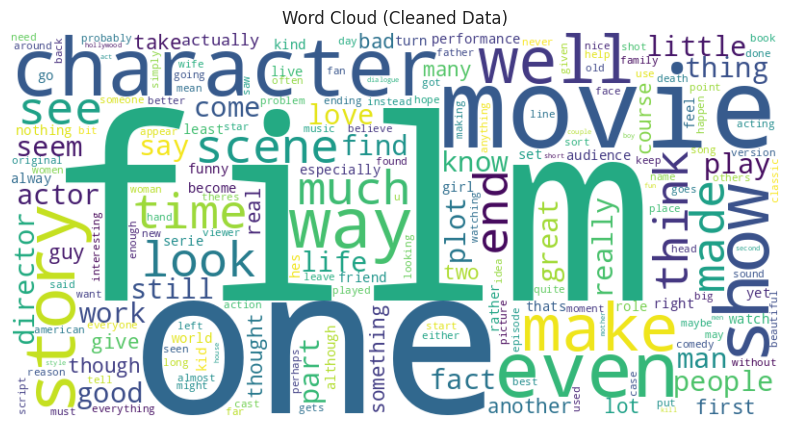

In [ ]:
# Word Cloud for cleaned text
all_text = " ".join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Cleaned Data)')
plt.show()

In [ ]:
# Train/Test Split
X = df['cleaned_review'].values
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values # Binary encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 40000
Testing samples: 10000


In [ ]:
# Initialize Vectorizer
tfidf_vec = TfidfVectorizer(max_features=5000, min_df=2, ngram_range=(1,2))

# Transform data
X_train_emb = tfidf_vec.fit_transform(X_train).toarray()
X_test_emb = tfidf_vec.transform(X_test).toarray()

print(f"TF-IDF Shape: {X_train_emb.shape}")

TF-IDF Shape: (40000, 5000)


In [ ]:
# Tokenize for Gensim
train_tokens = [s.split() for s in X_train]
test_tokens = [s.split() for s in X_test]

# Train Skip-gram (sg=1)
w2v_sg_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, sg=1, min_count=2)

def get_mean_vector(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_emb = np.array([get_mean_vector(s, w2v_sg_model) for s in train_tokens])
X_test_emb = np.array([get_mean_vector(s, w2v_sg_model) for s in test_tokens])

print(f"Skip-gram Shape: {X_train_emb.shape}")

Skip-gram Shape: (40000, 100)


In [ ]:
# Train CBOW (sg=0)
w2v_cbow_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, sg=0, min_count=2)

X_train_emb = np.array([get_mean_vector(s, w2v_cbow_model) for s in train_tokens])
X_test_emb = np.array([get_mean_vector(s, w2v_cbow_model) for s in test_tokens])

print(f"CBOW Shape: {X_train_emb.shape}")

CBOW Shape: (40000, 100)


## 5. Embedding Layer
Implement your specific embedding here (TF-IDF, Skip-gram (Word2Vec) and CBOW (Word2Vec)).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(max_features=5000, min_df=2, ngram_range=(1,2))
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf  = tfidf_vec.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (40000, 5000) (10000, 5000)


In [ ]:
from gensim.models import Word2Vec

train_tokens = [s.split() for s in X_train]
test_tokens  = [s.split() for s in X_test]

w2v_sg = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    sg=1,          # Skip-gram
    min_count=2,
    workers=4
)

def mean_pool(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

X_train_w2v_sg = np.vstack([mean_pool(t, w2v_sg) for t in train_tokens])
X_test_w2v_sg  = np.vstack([mean_pool(t, w2v_sg) for t in test_tokens])

print("Word2Vec Skip-gram shapes:", X_train_w2v_sg.shape, X_test_w2v_sg.shape)


Word2Vec Skip-gram shapes: (40000, 100) (10000, 100)


In [ ]:
w2v_cbow = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    sg=0,          # CBOW
    min_count=2,
    workers=4
)

X_train_w2v_cbow = np.vstack([mean_pool(t, w2v_cbow) for t in train_tokens])
X_test_w2v_cbow  = np.vstack([mean_pool(t, w2v_cbow) for t in test_tokens])

print("Word2Vec CBOW shapes:", X_train_w2v_cbow.shape, X_test_w2v_cbow.shape)


Word2Vec CBOW shapes: (40000, 100) (10000, 100)


In [ ]:
from sklearn.model_selection import train_test_split

# 1) Safety checks (prevents KeyError)
assert 'cleaned_review' in df.columns, "Missing 'cleaned_review'. Run preprocessing cell first."
assert 'sentiment' in df.columns, "Missing 'sentiment' column."

# 2) Features + labels
X = df['cleaned_review'].astype(str).values
y = (df['sentiment'] == 'positive').astype(int).values  # 1=positive, 0=negative

# 3) Stratified split (professional + stable results)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), " Test size:", len(X_test))
print("Train class counts [neg, pos]:", np.bincount(y_train))
print("Test class counts  [neg, pos]:", np.bincount(y_test))


Train size: 40000  Test size: 10000
Train class counts [neg, pos]: [20000 20000]
Test class counts  [neg, pos]: [5000 5000]


## 6. Model Architecture
Define your model (RNN, LSTM, GRU, or Traditional ML).

**Model**: Logistic Regression (linear classifier)

**Goal**: predict sentiment (positive vs negative)

**Why suitable**: works very well with TF-IDF sparse features and provides a strong baseline

**Decision rule**: learns weights for features and predicts probability using a sigmoid (logistic) function

In [ ]:
from sklearn.linear_model import LogisticRegression

LOGREG_PARAMS = {
    "max_iter": 1000,
    "solver": "liblinear",
    "C": 1.0,
    "random_state": 42
}

print("Logistic Regression parameters:", LOGREG_PARAMS)


Logistic Regression parameters: {'max_iter': 1000, 'solver': 'liblinear', 'C': 1.0, 'random_state': 42}


## 7.TF-IDF Embedding + Logistic Regression + Evaluation + Save Results

TF-IDF shapes: (40000, 5000) (10000, 5000)

=== Logistic Regression + TF-IDF ===
Accuracy: 0.8915
F1: 0.8925636201604119
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



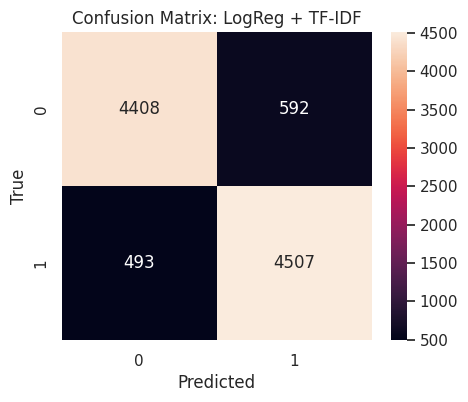

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Results list (create once)
try:
    results
except NameError:
    results = []

# 1) TF-IDF embedding
tfidf_vec = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

# 2) Train Logistic Regression
logreg_tfidf = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    C=1.0,
    random_state=42
)

logreg_tfidf.fit(X_train_tfidf, y_train)

# 3) Predict + Evaluate
y_pred = logreg_tfidf.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== Logistic Regression + TF-IDF ===")
print("Accuracy:", acc)
print("F1:", f1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix: LogReg + TF-IDF")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 4) Save result for final tables
results.append({
    "Model": "Logistic Regression",
    "Embedding": "TF-IDF (5k features, 1-2 grams)",
    "Accuracy": acc,
    "F1": f1
})


# 7.1. Word2Vec Skip-gram (Mean Pooling) + Logistic Regression

Word2Vec Skip-gram shapes: (40000, 100) (10000, 100)

=== Logistic Regression + Word2Vec Skip-gram ===
Accuracy: 0.8759
F1: 0.875763339673641
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5000
           1       0.88      0.87      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



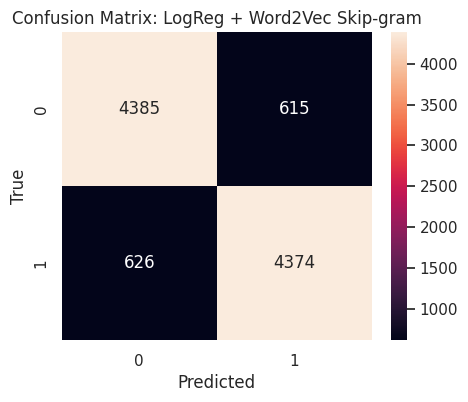

In [ ]:
from gensim.models import Word2Vec

# 1) Tokenize text for Word2Vec
train_tokens = [s.split() for s in X_train]
test_tokens  = [s.split() for s in X_test]

# 2) Train Word2Vec Skip-gram (sg=1)
w2v_sg = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    sg=1,          # Skip-gram
    min_count=2,
    workers=4
)

# 3) Mean pooling to get document vectors
def mean_pool(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

X_train_w2v_sg = np.vstack([mean_pool(t, w2v_sg) for t in train_tokens])
X_test_w2v_sg  = np.vstack([mean_pool(t, w2v_sg) for t in test_tokens])

print("Word2Vec Skip-gram shapes:", X_train_w2v_sg.shape, X_test_w2v_sg.shape)

# 4) Train Logistic Regression
logreg_w2v_sg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    C=1.0,
    random_state=42
)

logreg_w2v_sg.fit(X_train_w2v_sg, y_train)

# 5) Predict + Evaluate
y_pred = logreg_w2v_sg.predict(X_test_w2v_sg)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== Logistic Regression + Word2Vec Skip-gram ===")
print("Accuracy:", acc)
print("F1:", f1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix: LogReg + Word2Vec Skip-gram")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6) Save result
results.append({
    "Model": "Logistic Regression",
    "Embedding": "Word2Vec Skip-gram (100d, mean pooling)",
    "Accuracy": acc,
    "F1": f1
})


Word2Vec CBOW shapes: (40000, 100) (10000, 100)

=== Logistic Regression + Word2Vec CBOW ===
Accuracy: 0.8573
F1: 0.8578826810078677
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5000
           1       0.85      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



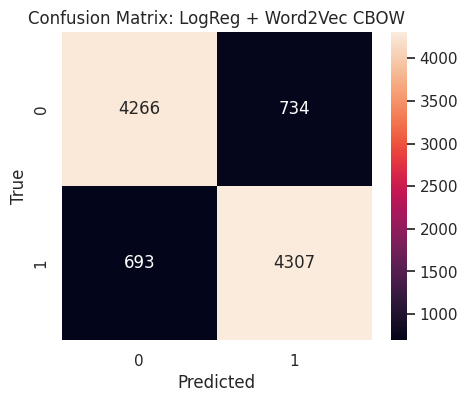

In [ ]:
# 1) Train Word2Vec CBOW (sg=0)
w2v_cbow = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    sg=0,          # CBOW
    min_count=2,
    workers=4
)

# 2) Mean pooling for document vectors
X_train_w2v_cbow = np.vstack([mean_pool(t, w2v_cbow) for t in train_tokens])
X_test_w2v_cbow  = np.vstack([mean_pool(t, w2v_cbow) for t in test_tokens])

print("Word2Vec CBOW shapes:", X_train_w2v_cbow.shape, X_test_w2v_cbow.shape)

# 3) Train Logistic Regression
logreg_w2v_cbow = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    C=1.0,
    random_state=42
)

logreg_w2v_cbow.fit(X_train_w2v_cbow, y_train)

# 4) Predict + Evaluate
y_pred = logreg_w2v_cbow.predict(X_test_w2v_cbow)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== Logistic Regression + Word2Vec CBOW ===")
print("Accuracy:", acc)
print("F1:", f1)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix: LogReg + Word2Vec CBOW")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 5) Save result
results.append({
    "Model": "Logistic Regression",
    "Embedding": "Word2Vec CBOW (100d, mean pooling)",
    "Accuracy": acc,
    "F1": f1
})


# Full Comparison Table (ALL 3 Embeddings)

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results)

# Sort by F1-score (best first)
results_df = results_df.sort_values(by="F1", ascending=False).reset_index(drop=True)

results_df


,Model,Embedding,Accuracy,F1
0,Logistic Regression,"TF-IDF (5k features, 1-2 grams)",0.8915,0.892564
1,Logistic Regression,"Word2Vec Skip-gram (100d, mean pooling)",0.8759,0.875763
2,Logistic Regression,"Word2Vec CBOW (100d, mean pooling)",0.8573,0.857883
